# 20200710-01SB-CNN Training with Nano 33 acquired audio

## Executive Summary

A SB-CNN model has been created and trained using 2 categories ('yes' and 'no') and 303 audio recordings , with audio obtained from a Nano 33 BLE Sense, which uses a PDM microphone @ 16000 Hz sample rate.

The SB-CNN model has achieved a 100% accuracy and 0.3161 validation loss, over 100 epochs with batch size 32.

The SB-CNN model has been converted into TFlite models, of varying data type and mode, and then tested again to validate accuracy and size of the resulting accuracy.

Accuracy of the resulting TFLite model is shown here.  There are others available, in the same result fold, depending on the final c++ implementation required, with the accompanying cpp (cc) file.  A tflite file is a binary file containing the raw byte array.  The typical file used is the cpp(cc) file.

```
tflite filename                                                                                                        size (bytes) accuracy
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_OPTIMIZE_FOR_LATENCY_int8.tflite                         65040 1.0000
```

## Method

In [ ]:
!pip install --quiet tensorflow==2.2.0
!pip install --quiet matplotlib

In [ ]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm

tf.config.experimental_run_functions_eagerly(True)
tf.debugging.set_log_device_placement(False)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available:  1
2.2.0


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.regularizers import l2

from tensorflow.python.ops import io_ops
from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
from tensorflow.audio import decode_wav

In [ ]:
base_path = '/content'
dataset_path = '/content/data'
build_path = '/content/build'
model_path = '/content/model'
desired_samples = 16000
sample_rate = 16000
window_size_ms = 30.0
window_step_ms = 20.0
# words = sorted(['_silence_','_unknown_','one', 'two','three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'zero', 'yes', 'no'])
# words = sorted(['_silence_','one', 'two','three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'zero', 'yes', 'no'])
words = sorted(['yes','no'])

validation_percentage = 10
testing_percentage = 10

In [ ]:
def create_model(label_count):
  conv_size = (3,3)
  conv_block = 'conv'
  downsample_size = (4,2)
  fully_connected = 64
  n_stages = None
  n_blocks_per_stage = None
  filters = 24
  kernels_growth = 2
  dropout = 0.5
  use_strides = False

  Conv2 = SeparableConv2D if conv_block == 'depthwise_separable' else Convolution2D
  kernel = conv_size

  strides, pool = (downsample_size, (1,1)) if use_strides else ((1,1), downsample_size)

  block1 = [
    Convolution2D(filters, kernel, padding = 'same', strides = strides,
                  # input_shape=(128,128,1), 
                  input_shape=(49,40,1),
                  data_format='channels_last',
                  kernel_initializer='random_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=pool),
    Activation('relu')
  ]

  block2 = [
    Conv2(filters*kernels_growth, kernel, padding='same', strides=strides,
           kernel_initializer='random_normal'),
    BatchNormalization(),
    MaxPooling2D(pool_size=pool),
    Activation('relu')
  ]

  block3 = [
    Conv2(filters * kernels_growth, kernel, padding='valid', strides=strides,
          kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu')
  ]

  backend = [
    Flatten(),
    Dropout(dropout),
    Dense(fully_connected, kernel_regularizer=l2(0.001), 
          kernel_initializer='random_normal'),
    Activation('relu'),
    Dropout(dropout),
    Dense(label_count, kernel_regularizer=l2(0.001), 
          kernel_initializer=('random_normal')),
    Activation('softmax')
  ]

  layers = block1 + block2 + block3 + backend
  model = Sequential(layers)

  return model

In [ ]:
model = create_model(len(words))

opt = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
loss = keras.losses.CategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=opt, loss=loss, metrics=metrics)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 49, 40, 24)        240       
_________________________________________________________________
batch_normalization (BatchNo (None, 49, 40, 24)        96        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 20, 24)        0         
_________________________________________________________________
activation (Activation)      (None, 12, 20, 24)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 20, 48)        10416     
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 20, 48)        192       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 10, 48)         0

(Optional) Skip training by loading the weights here

In [ ]:
# model.load_weights("/content/model_sbcnn_yn.h5")
# model.save_weights("/content/nano_speech_model_weights.h5")

## Load an Audio File

This routine generates spectrogram images using the micro_frontend transformation, for each audio file.

In [ ]:
def generate_spectrogram(sample_audio, is_silence):
  # Read the audio file
  audio_file = io_ops.read_file(sample_audio)

  # Decode the audio file 
  audio_data = decode_wav(audio_file, desired_channels=1, 
                          desired_samples=desired_samples)

  # Clamp values to limit input range
  background_clamp = tf.clip_by_value(audio_data.audio, -1.0, 1.0)

  # Conversion from Float32 to Int16 (i.e. -32768 to 32767)
  int16_input = tf.cast(tf.multiply(background_clamp, 32768), tf.int16)

  # Generate spectrogram
  micro_frontend = frontend_op.audio_microfrontend(int16_input, 
                                                sample_rate=sample_rate,
                                                window_size=window_size_ms, 
                                                window_step=window_step_ms,
                                                num_channels=40, 
                                                out_scale=1,
                                                out_type=tf.float32)
  
  # Downscales for micro controller
  output = tf.multiply(micro_frontend, (10.0 / 256.0))

  # Prepares silence
  if is_silence:
    output = tf.multiply(output, 0.0)

  #Changes from (49,40) to (1,49,40,1)
  output = tf.expand_dims(output, -1)
 
  # Return Float32 values from 0.0 to 26.0
  return output

The audio which was acquired from the Nano 33 BLE Sense has been transfered over serial, then written into wav files, and then compressed into a single Zip file for easy transfer. "Nano33Commands(02).zip"

In [ ]:
nano_audio_path = '/content/drive/My Drive/Analysis/Research/20200710-01'
!mkdir -p '/content/data'
!cp '$nano_audio_path/Nano33Commands(02).zip' '/content/data/'

As it was created on a Mac, there are other files which are not required

In [ ]:
!unzip -n -q '/content/data/Nano33Commands(02).zip' -d '/content/data'
!rm -rf '/content/data/__MACOSX'
!rm -rf '/content/data/*.pkl'

Load the files to ensure that the audio is accessible

In [ ]:
all_files = []

for word in words:
  for f in os.listdir('/content/data'):
    if f.startswith(f'audio_{word}_') and f.endswith('.wav'):
      all_files.append((word, f))
print(words)
print(len(all_files))
print(all_files)

['no', 'yes']
303
[('no', 'audio_no__109.wav'), ('no', 'audio_no__81.wav'), ('no', 'audio_no__111.wav'), ('no', 'audio_no__80.wav'), ('no', 'audio_no__33.wav'), ('no', 'audio_no__91.wav'), ('no', 'audio_no__110.wav'), ('no', 'audio_no__64.wav'), ('no', 'audio_no__103.wav'), ('no', 'audio_no__44.wav'), ('no', 'audio_no__146.wav'), ('no', 'audio_no__125.wav'), ('no', 'audio_no__37.wav'), ('no', 'audio_no__52.wav'), ('no', 'audio_no__6.wav'), ('no', 'audio_no__120.wav'), ('no', 'audio_no__40.wav'), ('no', 'audio_no__136.wav'), ('no', 'audio_no__97.wav'), ('no', 'audio_no__126.wav'), ('no', 'audio_no__46.wav'), ('no', 'audio_no__74.wav'), ('no', 'audio_no__8.wav'), ('no', 'audio_no__94.wav'), ('no', 'audio_no__150.wav'), ('no', 'audio_no__137.wav'), ('no', 'audio_no__63.wav'), ('no', 'audio_no__38.wav'), ('no', 'audio_no__100.wav'), ('no', 'audio_no__4.wav'), ('no', 'audio_no__98.wav'), ('no', 'audio_no__73.wav'), ('no', 'audio_no__114.wav'), ('no', 'audio_no__32.wav'), ('no', 'audio_no__2

As there are only a small number of wav files in the source set, they can be easily converted in one hit, into spectrograms.

In [ ]:
spectrograms = []
labels = []
filenames = []

for sample_file in all_files:
  print(sample_file)
  is_silence = '_silence_' in sample_file[1]

  spectrogram = generate_spectrogram(os.path.join('/content/data', sample_file[1]), is_silence)

  spectrograms.append(spectrogram)
  labels.append(words.index(sample_file[0]))
  filenames.append(sample_file[1])

X_np = np.array(spectrograms)
y_np = keras.utils.to_categorical(np.array(labels))

('no', 'audio_no__109.wav')
('no', 'audio_no__81.wav')
('no', 'audio_no__111.wav')
('no', 'audio_no__80.wav')
('no', 'audio_no__33.wav')
('no', 'audio_no__91.wav')
('no', 'audio_no__110.wav')
('no', 'audio_no__64.wav')
('no', 'audio_no__103.wav')
('no', 'audio_no__44.wav')
('no', 'audio_no__146.wav')
('no', 'audio_no__125.wav')
('no', 'audio_no__37.wav')
('no', 'audio_no__52.wav')
('no', 'audio_no__6.wav')
('no', 'audio_no__120.wav')
('no', 'audio_no__40.wav')
('no', 'audio_no__136.wav')
('no', 'audio_no__97.wav')
('no', 'audio_no__126.wav')
('no', 'audio_no__46.wav')
('no', 'audio_no__74.wav')
('no', 'audio_no__8.wav')
('no', 'audio_no__94.wav')
('no', 'audio_no__150.wav')
('no', 'audio_no__137.wav')
('no', 'audio_no__63.wav')
('no', 'audio_no__38.wav')
('no', 'audio_no__100.wav')
('no', 'audio_no__4.wav')
('no', 'audio_no__98.wav')
('no', 'audio_no__73.wav')
('no', 'audio_no__114.wav')
('no', 'audio_no__32.wav')
('no', 'audio_no__28.wav')
('no', 'audio_no__19.wav')
('no', 'audio_no__

Inspect the shape of the X_np numpy spectrogram tensor

In [ ]:
X_np.shape

(303, 49, 40, 1)

Inspect the shape of the y_np labels numpy input tensor

In [ ]:
y_np.shape

(303, 2)

## (Alternative) Load from audio file spectrograms

Split the numpy spectrograms and labels into training, validation and testing collections, after shuffling the lists.

In [ ]:
np.random.seed(512313)

all_data = list(zip(X_np, y_np))
np.random.shuffle(all_data)

validation_count = int(len(all_data) * validation_percentage /100)
testing_count = int(len(all_data) * testing_percentage / 100)

print(f'{len(all_data)} Training {len(all_data) - validation_count - testing_count} Validation {validation_count} Testing {testing_count}')

# Testing set
testing = all_data[0:testing_count]
testing_images, testing_labels = zip(*testing)
testing_images = np.array(testing_images)
testing_labels = np.array(testing_labels)

# Validation set
validation = all_data[testing_count:validation_count + testing_count]
validation_images, validation_labels = zip(*validation)
validation_images = np.array(validation_images)
validation_labels = np.array(validation_labels)

# Training set
training = all_data[validation_count + testing_count:-1]
training_images, training_labels = zip(*training)
training_images = np.array(training_images)
training_labels = np.array(training_labels)

print(f'Training {training_images.shape} {training_labels.shape}')
print(f'Validation {validation_images.shape} {validation_labels.shape}')
print(f'Testing {testing_images.shape} {testing_labels.shape}')

303 Training 243 Validation 30 Testing 30
Training (242, 49, 40, 1) (242, 2)
Validation (30, 49, 40, 1) (30, 2)
Testing (30, 49, 40, 1) (30, 2)


### (Alternative) Load from numpy files

If the spectrograms and labels are already written to disk ('below'), they can be loaded here, to skip generating the spectrograms, saving time.

In [ ]:
X_np = np.load('/content/drive/My Drive/Analysis/Research/20200710-02/yn_spectrograms.np.npy')
y_np = np.load('/content/drive/My Drive/Analysis/Research/20200710-02/yn_labels.np.npy')
training_images = np.load('/content/drive/My Drive/Analysis/Research/20200710-02/yn_training_images.np.npy')
training_labels = np.load('/content/drive/My Drive/Analysis/Research/20200710-02/yn_training_labels.np.npy')
validation_images = np.load('/content/drive/My Drive/Analysis/Research/20200710-02/yn_validation_images.np.npy')
validation_labels = np.load('/content/drive/My Drive/Analysis/Research/20200710-02/yn_validation_labels.np.npy')
testing_images = np.load('/content/drive/My Drive/Analysis/Research/20200710-02/yn_testing_images.np.npy')
testing_labels = np.load('/content/drive/My Drive/Analysis/Research/20200710-02/yn_testing_labels.np.npy')

## Train

Training is conducted in this section, using a EarlyStoppping monitor to avoid excessive training iterations and to restore the best weights after training completes.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

In [ ]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=1,
    mode='min',
    baseline=None,
    restore_best_weights=True
)

A quick check to determine if a GPU is being used.

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
batch_size=32

model.fit(training_images, training_labels, epochs=100, batch_size=batch_size, shuffle=True, validation_data=(validation_images,validation_labels),  callbacks=[early_stopping_monitor], 
          verbose=1)

Epoch 1/100
8/8 [==============================] - 0s 40ms/step - loss: 0.6706 - accuracy: 0.7273 - val_loss: 0.6508 - val_accuracy: 1.0000
Epoch 2/100
8/8 [==============================] - 0s 30ms/step - loss: 0.4958 - accuracy: 0.9463 - val_loss: 0.5383 - val_accuracy: 1.0000
Epoch 3/100
8/8 [==============================] - 0s 26ms/step - loss: 0.4086 - accuracy: 0.9917 - val_loss: 0.4548 - val_accuracy: 1.0000
Epoch 4/100
8/8 [==============================] - 0s 27ms/step - loss: 0.3875 - accuracy: 0.9959 - val_loss: 0.4345 - val_accuracy: 1.0000
Epoch 5/100
8/8 [==============================] - 0s 28ms/step - loss: 0.3761 - accuracy: 0.9959 - val_loss: 0.4242 - val_accuracy: 1.0000
Epoch 6/100
8/8 [==============================] - 0s 26ms/step - loss: 0.3711 - accuracy: 1.0000 - val_loss: 0.4069 - val_accuracy: 1.0000
Epoch 7/100
8/8 [==============================] - 0s 25ms/step - loss: 0.3683 - accuracy: 1.0000 - val_loss: 0.3904 - val_accuracy: 1.0000
Epoch 8/100
8/8 [===

## Evaluation of Model

Evaluate the model, by first inspecting the spectrograms, then running inference to validate predictions and accuracy.

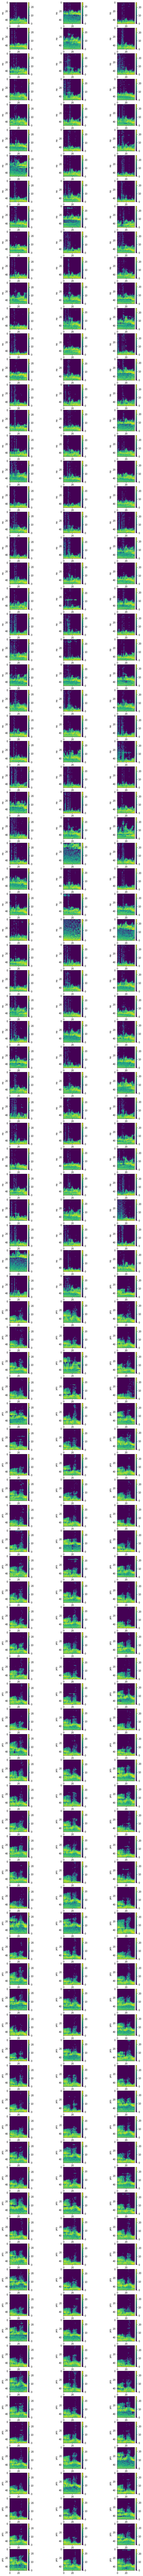

In [ ]:
num_rows = len(filenames)
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(len(filenames)):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plt.imshow(np.flip(X_np[i,:,:,0]))
  plt.colorbar()
  plt.grid(False)
  # plt.title(filenames[i])
  plt.ylabel(words[np.argmax(y_np[i])])

plt.show()

## Making Predictions

The predictions which are run here, used the trained model, and the testing data set, to check if the model can accurately infer the category for each sample.

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Softmax
probability_model = Sequential([model, Softmax()])

Acquire predictions by running inference

In [ ]:
example_number = 0
predictions = probability_model.predict(testing_images)
labels = np.argmax(testing_labels, axis=1)

Some quick stats for a single record

In [ ]:
print(f'Predictions {predictions[example_number]}')
print(f'Predictions (Max) Index {np.argmax(predictions[example_number])}')
print(f'Word {words[np.argmax(predictions[example_number])]}')

Predictions [0.26898208 0.73101795]
Predictions (Max) Index 1
Word yes


Some helpers to show the predictions beside the input feature for the testing dataset

In [ ]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  # plt.imshow(np.flip(np.transpose(img)))
  plt.imshow(np.flip(img))
  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(words[predicted_label],
                                100*np.max(predictions_array),
                                words[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(len(words)),  predictions_array, 
                     color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

Plot the predictions as a list

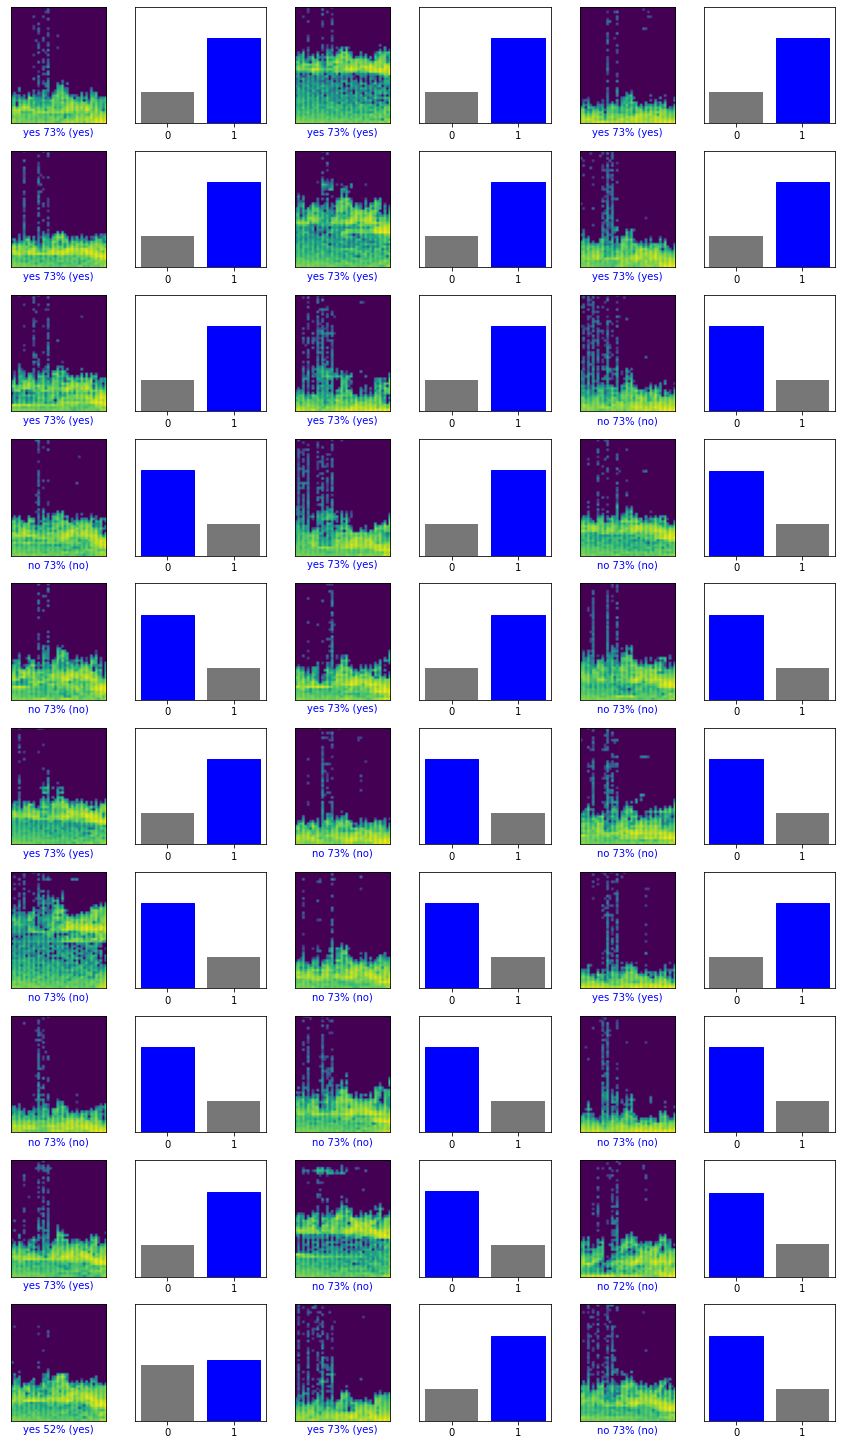

In [ ]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = len(testing_images)
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in range(len(testing_images)):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], labels, X_np[:,:,:,0])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], labels)

plt.tight_layout()
plt.show()

Accuracy:

In [ ]:
predicted_label = np.argmax(predictions, axis=1)
prediction_results = [(p_label, label, p_label == label) for p_label, label in zip(predicted_label, labels)]
correct_results = sum([1 for (p_label, label, match) in prediction_results if match])
accuracy = correct_results / len(labels)
print(accuracy)


1.0


## Saving data

Save the results to disk ensures they can be easily loaded again

In [ ]:
model.save_weights('/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn.h5')

In [ ]:
model.save('/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn/assets


In [ ]:
np.save('/content/drive/My Drive/Analysis/Research/20200710-02/yn_spectrograms.np',X_np)
np.save('/content/drive/My Drive/Analysis/Research/20200710-02/yn_labels.np',y_np)
np.save('/content/drive/My Drive/Analysis/Research/20200710-02/yn_training_images.np',training_images)
np.save('/content/drive/My Drive/Analysis/Research/20200710-02/yn_training_labels.np',training_labels)
np.save('/content/drive/My Drive/Analysis/Research/20200710-02/yn_validation_images.np',validation_images)
np.save('/content/drive/My Drive/Analysis/Research/20200710-02/yn_validation_labels.np',validation_labels)
np.save('/content/drive/My Drive/Analysis/Research/20200710-02/yn_testing_images.np',testing_images)
np.save('/content/drive/My Drive/Analysis/Research/20200710-02/yn_testing_labels.np',testing_labels)

## TFLite Conversion

These are simplistic one shot TFLite conversions.  In reality, we use another technique below to loop over a range of quantization options in the section below.

In [ ]:
MODEL_NO_QUANT_TFLITE = 'model_sbcnn_yn_no_quant.tflite'
MODEL_QUANT_TFLITE = 'model_sbcnn_yn_quant.tflite'
MODEL_QUANT_TFLITE_UINT8 = 'model_sbcnn_yn_quant_uint8.tflite'

Convert without quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
model_no_quant_tflite = converter.convert()
noquantized_size = open(f'/content/drive/My Drive/Analysis/Research/20200710-02/{MODEL_NO_QUANT_TFLITE}', 'wb').write(model_no_quant_tflite)

When quantization is applied, a representative dataset is required, to accurately get two quantization variables per layer, called the zero point offset and scaling factor. 

These two variables ensure that when a weight or bias is interpretted from a low precision datatype, it is able to accurate represent the values with the smallest possible error.

All weights share a single zero point offset and scaling factor.  All biases typically share a different set of these variables also. 

In [ ]:
def representative_dataset():
  for i in range(len(testing_images)):
    yield([testing_images[i:i+1,:,:,:]])

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset

model_quant_tflite = converter.convert()
quantized_size = open(f'/content/drive/My Drive/Analysis/Research/20200710-02/{MODEL_QUANT_TFLITE}', 'wb').write(model_quant_tflite)

### TFLite with Quantization (Parametric Study)


Using the helper functions below, interate over the various options for quantizing the model, then assess the accuracy for each tflite file, and convert it to a flat buffer 'cc'/'cpp' file for easy use in a project.

In [ ]:
!apt-get install --quiet xxd

def save_flat_buffer(tflite_path, flatbuffer_path):
  !echo "$flatbuffer_path"
  !xxd -i "$tflite_path" > "$flatbuffer_path"
  return os.path.getsize(flatbuffer_path)

def save_tflite_model(tflite_model, tflite_path):
  bytes_written = open(tflite_path, 'wb').write(tflite_model)
  return bytes_written

def print_tflite_model(tflite_path):
  interpreter = tf.lite.Interpreter(model_path=tflite_path)
  interpreter.allocate_tensors()

  print(interpreter.get_input_details())
  print(interpreter.get_output_details())
  print('tensors = [')
  for l in interpreter.get_tensor_details():
    print(f'index:{l["index"]}, name:{l["name"]}, shape:{l["shape"]}, dtype: {l["dtype"]}')
  print(']')

def get_tflite_size(tflite_path):
  return os.path.getsize(tflite_path)

def get_tflite_accuracy(tflite_path, X_np, y_np, classes):
  with tf.io.gfile.GFile(tflite_path,'rb') as f:
    model_content = f.read()
  
  interpreter = tf.lite.Interpreter(model_content=model_content)
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()
  output_details =interpreter.get_output_details()

  input_index = input_details[0]['index']
  input_dtype = input_details[0]['dtype']

  input_scale, input_zero_point = input_details[0]['quantization']
  
  if input_scale > 0.0 or input_zero_point > 0:
    X_np = X_np / input_scale + input_zero_point
    X_np = X_np.astype(input_dtype)

  accurate_count = 0
  total_count = 0
  for (X, y) in zip(X_np, y_np):
    X = tf.expand_dims(X, 0).numpy()

    #Set the input tensor for inference
    if input_dtype == np.int8:
      interpreter.set_tensor(input_index, X.astype(np.int8))
    elif input_dtype == np.uint8:
      interpreter.set_tensor(input_index, X.astype(np.uint8))
    elif input_dtype == np.float32:
      interpreter.set_tensor(input_index, X.astype(np.float32))
    else:
      interpreter.set_tensor(input_index, X)
    
    # Run the inference
    interpreter.invoke()
    output = interpreter.get_tensor(output_details[0]["index"])[0]

    #Predict
    p = output.argmax()
    p_label = classes[p]
    l =  np.argmax(y)
    l_label = classes[l]
    # print(f'{l} {l_label} {p} {p_label}')
    accurate_count += (l == p)
    total_count += 1
  
  return accurate_count * 1.0 / total_count

def convert_keras_to_tflite(model, optimization, dtype, representative_dataset):
  converter = tf.lite.TFLiteConverter.from_keras_model(model)
  if optimization is not None:
    converter.optimizations = [optimization]
    
  if dtype == 'float32':
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]
    converter.inference_input_type = tf.float32
    converter.inference_output_type = tf.float32
  elif dtype == 'int8':
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    converter.inference_type = tf.int8
  elif dtype == 'uint8':
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8
    converter.inference_type = tf.uint8
  elif dtype == 'iu8':
    converter.representative_dataset = representative_dataset
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_type = tf.int8
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.uint8
  elif dtype == 'int16':
    converter.target_spec.supported_ops = [tf.lite.OpsSet.EXPERIMENTAL_TFLITE_BUILTINS_ACTIVATIONS_INT16_WEIGHTS_INT8]
    converter.inference_input_type = tf.float32
    converter.inference_output_type = tf.float32

  try:
    converter.allow_custom_ops = True
    return converter.convert()
  except Exception as e:
    print(f'Failed to convert model ({str(optimization)},{str(dtype)}) {e}')
    return None

Reading package lists...
Building dependency tree...
Reading state information...
xxd is already the newest version (2:8.0.1453-1ubuntu1.3).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 33 not upgraded.


In [ ]:
optimizations = [None, tf.lite.Optimize.DEFAULT, tf.lite.Optimize.OPTIMIZE_FOR_LATENCY, tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
dtypes = [None, 'int8', 'uint8', 'float32','iu8']
tflite_conversions = []

for optimization in optimizations:
  for dtype in dtypes:

    tflite_bytes = 0
    tflite_accuracy = 0.0
    tflite_path = f'/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_{optimization}_{dtype}.tflite'
    print(tflite_path)

    # Convert
    tflite_model = convert_keras_to_tflite(model, optimization, dtype, representative_dataset)
    if tflite_model: 
      # Write to disk
      tflite_bytes = save_tflite_model(tflite_model, tflite_path)

      # Write flatbuffer to disk
      flatbuffer_path = f'/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_{optimization}_{dtype}.cpp'
      save_flat_buffer(tflite_path, flatbuffer_path)

      # Calculate accuracy
      tflite_accuracy = get_tflite_accuracy(tflite_path, testing_images, testing_labels, words)
    tflite_conversions.append((tflite_path, tflite_bytes,tflite_accuracy, optimization, dtype))

/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_None_None.tflite
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_None_None.cpp
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_None_int8.tflite
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_None_int8.cpp
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_None_uint8.tflite
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_None_uint8.cpp
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_None_float32.tflite
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_None_float32.cpp
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_None_iu8.tflite
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_None_iu8.cpp
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_DEFAULT_None.tflite
/content/drive/My Drive/Analysis/Research/20200710-02/model_

We can inspect the resulting TFLite tensors for each TFLite result, and thereby deduce whether the conversion was successful, in enforcing full quantization.

When int8 quantization is used, weights and inputs are int8, but biases and the activation output are also int32.

When float32 quantization is used, all weights, inputs, biases and activation results are float32.

In [ ]:
# optimizations = [None, tf.lite.Optimize.DEFAULT, tf.lite.Optimize.OPTIMIZE_FOR_LATENCY, tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
# dtypes = [None, 'int8', 'uint8', 'float32', 'int16']

for optimization in optimizations:
  for dtype in dtypes:
    tflite_path = f'/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_{optimization}_{dtype}.tflite'
    print(tflite_path)
    if os.path.exists(tflite_path):
      print_tflite_model(tflite_path)

/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_None_None.tflite
[{'name': 'conv2d_input', 'index': 0, 'shape': array([ 1, 49, 40,  1], dtype=int32), 'shape_signature': array([ 1, 49, 40,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 22, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([1, 2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
tensors = [
index:0, name:conv2d_input, shape:[ 1 49 40  1], dtype: <class 'numpy.float32'>
index:1, name:sequential/dense/BiasAdd/ReadVariableOp, shape:[64], dtype: <class 'numpy.float32'>
index:2, name:sequential/de

## Results

Typical speech_command audio data is manipulated into a 1960x1 flattened array 

This SB-CNN network has been trained with an input shape of 49x40x1

The typical audio has been converted also, such that the input data range is 0.0 to 26.0 in size.

Once quantization is applied, the audio data has a zero_offset and scaling factor applied such that the low precision data type (int8 or uint) can represent the maximum expected range of data.


Bulk inspect TFLite model result

In [ ]:
print(f'sample range {testing_images[0].min()} {testing_images[0].max()}')
print(f'sample range {testing_images[0].astype(np.int8).min()} {testing_images[0].astype(np.int8).max()}')

sample range 0.0 25.46875
sample range 0 25


In [ ]:
print(f'{"tflite filename":118s} {"size (bytes)":s} {"accuracy":s}')
for tflite_path, tflite_bytes,tflite_accuracy, optimization, dtype in tflite_conversions:
  print(f'{tflite_path:120s} {tflite_bytes:10d} {tflite_accuracy:.4f}')

tflite filename                                                                                                        size (bytes) accuracy
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_None_None.tflite                                        227736 1.0000
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_None_int8.tflite                                         65040 1.0000
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_None_uint8.tflite                                        65040 1.0000
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_None_float32.tflite                                     227736 1.0000
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_None_iu8.tflite                                          65040 1.0000
/content/drive/My Drive/Analysis/Research/20200710-02/model_sbcnn_yn_DEFAULT_None.tflite                                      60840 1.0000
/content/drive/My Drive/A

### TFLite Inspection

In [ ]:
# quantized_model_bytes = open(MODEL_QUANT_INT8_TFLITE, 'rb').read()
interpreter = tf.lite.Interpreter(model_path=f'/content/drive/My Drive/Analysis/Research/20200710-02/{MODEL_QUANT_TFLITE}')
interpreter.allocate_tensors()

In [ ]:
print(interpreter.get_input_details())
print(interpreter.get_output_details())

for l in interpreter.get_tensor_details():
  print(f'Layer: {l["index"]} {l["name"]} {l["shape"]} {l["dtype"]}')

[{'name': 'conv2d_input', 'index': 23, 'shape': array([ 1, 49, 40,  1], dtype=int32), 'shape_signature': array([ 1, 49, 40,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[{'name': 'Identity', 'index': 24, 'shape': array([1, 2], dtype=int32), 'shape_signature': array([1, 2], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Layer: 0 conv2d_input_int8 [ 1 49 40  1] <class 'numpy.int8'>
Layer: 1 sequential/dense/BiasAdd/ReadVariableOp [64] <class 'numpy.int32'>
Layer: 2 sequential/dense_1/BiasAdd/ReadVariableOp [2] <class 'numpy.int32'>
Layer: 3 sequential/flatten/Const [2] <class 'numpy.int32'>
Layer: 4 std.constant [24] 

In [ ]:
if tf.__version__.startswith('1.'):
  operations = sorted([ops.op for ops in tf.lite.experimental.get_potentially_supported_ops()])
  print(operations)